In [ ]:
Step 3: Choosing a Data Augmentation Technique

In [9]:
import pandas as pd
import smogn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
data = pd.read_csv('/home/lola/machine-learning-project/famd_data.csv')

dist_matrix:   0%|          | 0/1455 [00:00<?, ?it/s]

r_index: 100%|##########| 127/127 [00:00<00:00, 2383.04it/s]


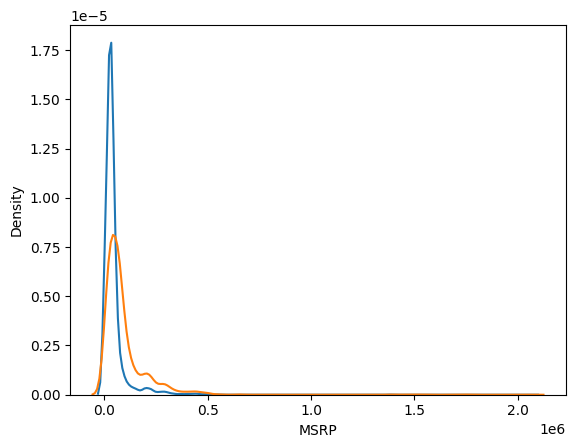

In [14]:
try:
    data_smogn = smogn.smoter(data=data, y='MSRP')
    sns.kdeplot(data['MSRP'], label='Original')
    sns.kdeplot(data_smogn['MSRP'], label='Modified')
    plt.show()
except ValueError:

    print("Oops! Synthetic data contains missing values.")
   
    data = data.dropna()
   
    data_smogn = smogn.smoter(data=data, y='MSRP')
    sns.kdeplot(data['MSRP'], label='Original')
    sns.kdeplot(data_smogn['MSRP'], label='Modified')
    plt.show()



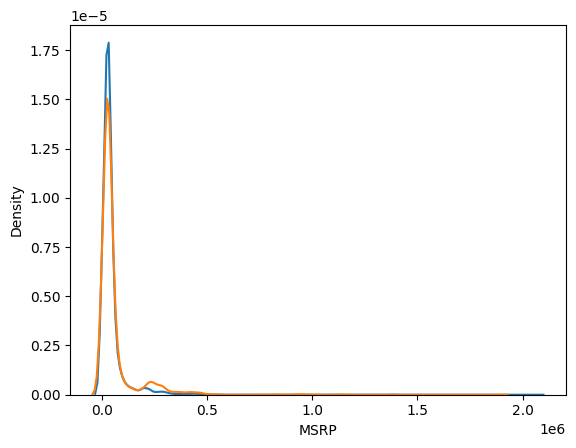

In [16]:
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    return iqr

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relevance_function(target_values):
    iqr = calculate_iqr(target_values)
    mean = np.mean(target_values)
    normalized_values = (target_values - mean) / iqr
    sigmoid_scores = sigmoid(normalized_values)
    return sigmoid_scores

def get_synth_cases(D, target, o=200, k=3, categorical_col=[]):
    new_cases = []
    ng = o // 100
    for index, case in D.iterrows():
        if case.isnull().any():  
            continue
        
        knn = KNeighborsRegressor(n_neighbors=k+1)
        knn.fit(D.drop(columns=[target]).values, D[[target]])
        neighbors = knn.kneighbors(case.drop(labels=[target]).values.reshape(1, -1), return_distance=False).reshape(-1)
        neighbors = np.delete(neighbors, np.where(neighbors == index))
        
        for i in range(0, ng):
            x = D.iloc[neighbors[np.random.randint(k)]]
            attr = {}
            for a in D.columns:
                if a == target:
                    continue
                if a in categorical_col:
                    if np.random.randint(2) == 0:
                        attr[a] = case[a]
                    else:
                        attr[a] = x[a]
                else:
                    diff = case[a] - x[a]
                    attr[a] = case[a] + np.random.randint(2) * diff
            new = np.array(list(attr.values()))
            d1 = cosine_similarity(new.reshape(1, -1), case.drop(labels=[target]).values.reshape(1, -1))[0][0]
            d2 = cosine_similarity(new.reshape(1, -1), x.drop(labels=[target]).values.reshape(1, -1))[0][0]
            attr[target] = (d2 * case[target] + d1 * x[target]) / (d1 + d2)
            new_cases.append(pd.DataFrame([attr]))
                    
    return new_cases


def SmoteR(D, target, th=0.999, o=200, u=100, k=3, categorical_col=[]):
    y_bar = D[target].median()

    rareL = D[(relevance_function(D[target]) > th) & (D[target] > y_bar)]
    new_casesL = get_synth_cases(rareL, target, o, k, categorical_col)

    rareH = D[(relevance_function(D[target]) > th) & (D[target] < y_bar)]
    new_casesH = get_synth_cases(rareH, target, o, k, categorical_col)

    new_cases = pd.concat(new_casesL + new_casesH, ignore_index=True)

    norm_cases = D[relevance_function(D[target]) <= th]
    nr_norm = int(len(norm_cases) * u / 100)
    norm_cases = norm_cases.sample(min(len(D[relevance_function(D[target]) <= th]), nr_norm))

    new_D = pd.concat([new_cases, norm_cases], ignore_index=True)

    return new_D

Xs = SmoteR(data, target='MSRP', th=0.999, o=300, u=100, k=10)

sns.kdeplot(data['MSRP'], label = 'Original')
sns.kdeplot(Xs['MSRP'], label = 'Modified')
plt.show()